Define variables for computation

In [65]:
# What company to look up, symbol and lower case name
SYMBOL="BKNG" # e.g. "TSLA"
KEYWORD="Booking holdings" # e.g. "tesla"

# What timeframe to lookup as a tuple e.g. (2023, 10, 29)
# if undefined, then it looks up the last month
START_DATE = (2022, 10, 29)
END_DATE = (2023, 10, 29)

Import packages

In [66]:
%load_ext autoreload
%autoreload 2

import importlib
import yfinance as yf
from transformers import pipeline
from datetime import datetime
import scraper

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Scrape the news from gnews. This takes a while...

(see implementation in scraper.py)

In [67]:
importlib.reload(scraper)

articles = scraper.get_articles(KEYWORD, START_DATE, END_DATE)

articles

Getting articles...
Start querying GNews


10/29/2023 03:05:24 PM - Article `download()` failed with 403 Client Error: Forbidden for url: https://www.investing.com/analysis/pro-picks-4-sizzling-summer-stocks--booking-holdings-leads-the-way-200639288 on URL https://consent.google.com/m?continue=https://news.google.com/rss/articles/CBMib2h0dHBzOi8vd3d3LmludmVzdGluZy5jb20vYW5hbHlzaXMvcHJvLXBpY2tzLTQtc2l6emxpbmctc3VtbWVyLXN0b2Nrcy0tYm9va2luZy1ob2xkaW5ncy1sZWFkcy10aGUtd2F5LTIwMDYzOTI4ONIBd2h0dHBzOi8vbS5pbnZlc3RpbmcuY29tL2FuYWx5c2lzL3Byby1waWNrcy00LXNpenpsaW5nLXN1bW1lci1zdG9ja3MtLWJvb2tpbmctaG9sZGluZ3MtbGVhZHMtdGhlLXdheS0yMDA2MzkyODg_YW1wTW9kZT0x?oc%3D5&gl=NL&m=0&pc=n&cm=2&hl=en-US&src=1
10/29/2023 03:05:55 PM - Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/greatspeculations/2022/12/20/booking-holdings-stock-down-7-over-ten-days-whats-next/ on URL https://consent.google.com/m?continue=https://news.google.com/rss/articles/CBMicWh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMv

{datetime.datetime(2023, 9, 25, 0, 0): ['BRUSSELS, Sept 25 (Reuters) - Booking Holdings\' (BKNG.O) proposed 1.63 billion euro ($1.7 billion) purchase of Swedish peer ETraveli Group was blocked by EU antitrust authorities on Monday after the company failed to allay concerns about its dominance in online hotel reservations.\n\nThe European Commission, which acts as the competition watchdog in the 27-country European Union, said Booking\'s remedies were not sufficient to address its concerns, confirming a Reuters story earlier this month.\n\nThe veto suggests that EU regulators may be taking a tougher stance on mergers in the digital sector.\n\nEU antitrust chief Didier Reynders said the travel market was becoming more digital, in particular the online travel agency (OTA) market which includes hotels, flights, car rentals and attractions.\n\nHotel OTAs are worth about 40 billion euros annually, the largest and most profitable segment of the OTA sector.\n\n"The combination of network effec

Now fetch stock data

In [68]:
tsla = yf.Ticker(SYMBOL)

sd = datetime(START_DATE[0], START_DATE[1], START_DATE[2])
ed = datetime(END_DATE[0], END_DATE[1], END_DATE[2])

price_history = tsla.history(start=sd, end=ed)

print(price_history)

                                  Open         High          Low        Close  \
Date                                                                            
2022-10-31 00:00:00-04:00  1870.910034  1885.339966  1837.839966  1869.479980   
2022-11-01 00:00:00-04:00  1891.250000  1927.000000  1886.040039  1889.520020   
2022-11-02 00:00:00-04:00  1862.790039  1884.729980  1771.319946  1778.180054   
2022-11-03 00:00:00-04:00  1849.000000  1902.699951  1822.760010  1825.729980   
2022-11-04 00:00:00-04:00  1884.829956  1916.150024  1852.099976  1874.400024   
...                                ...          ...          ...          ...   
2023-10-23 00:00:00-04:00  2753.760010  2841.459961  2742.000000  2819.540039   
2023-10-24 00:00:00-04:00  2836.949951  2858.899902  2817.239990  2835.370117   
2023-10-25 00:00:00-04:00  2822.620117  2851.520020  2806.870117  2812.919922   
2023-10-26 00:00:00-04:00  2795.550049  2818.719971  2733.040039  2742.689941   
2023-10-27 00:00:00-04:00  2

Now, we can process this and get the sentiment for all articles

In [69]:
sentiment_per_day = {}

# Go through the articles per day
for date in articles:
  group = articles[date]
  
  score = 0
  
  for article in group:
    # Get the first 512 characters, the model cant handle more.
    sc = sentiment_pipeline(article[:512])[0]
    if sc['label'] == 'POSITIVE':
      score += sc['score']
    else:
      score -= sc['score']
      
  sentiment_per_day[date] = score
      
sentiment_per_day

{datetime.datetime(2023, 9, 25, 0, 0): -2.2360758185386658,
 datetime.datetime(2023, 8, 3, 0, 0): -2.057734727859497,
 datetime.datetime(2023, 6, 27, 0, 0): 0.9809654355049133,
 datetime.datetime(2023, 5, 4, 0, 0): -0.9954766631126404,
 datetime.datetime(2022, 11, 2, 0, 0): 0.9877312779426575,
 datetime.datetime(2023, 2, 23, 0, 0): 1.9910478591918945,
 datetime.datetime(2023, 6, 26, 0, 0): -0.9137199521064758,
 datetime.datetime(2023, 7, 10, 0, 0): -0.12217468023300171,
 datetime.datetime(2023, 6, 7, 0, 0): 0.8226590752601624,
 datetime.datetime(2023, 10, 3, 0, 0): 0.9976451992988586,
 datetime.datetime(2023, 10, 20, 0, 0): -0.7174782752990723,
 datetime.datetime(2023, 1, 11, 0, 0): 0.9992324113845825,
 datetime.datetime(2023, 5, 21, 0, 0): -0.9955604076385498,
 datetime.datetime(2023, 6, 9, 0, 0): -2.921788454055786,
 datetime.datetime(2023, 10, 23, 0, 0): 0.6820212602615356,
 datetime.datetime(2023, 10, 11, 0, 0): 0.9857866764068604,
 datetime.datetime(2023, 8, 10, 0, 0): -1.97368401

Now link the price history and news-sentiment together

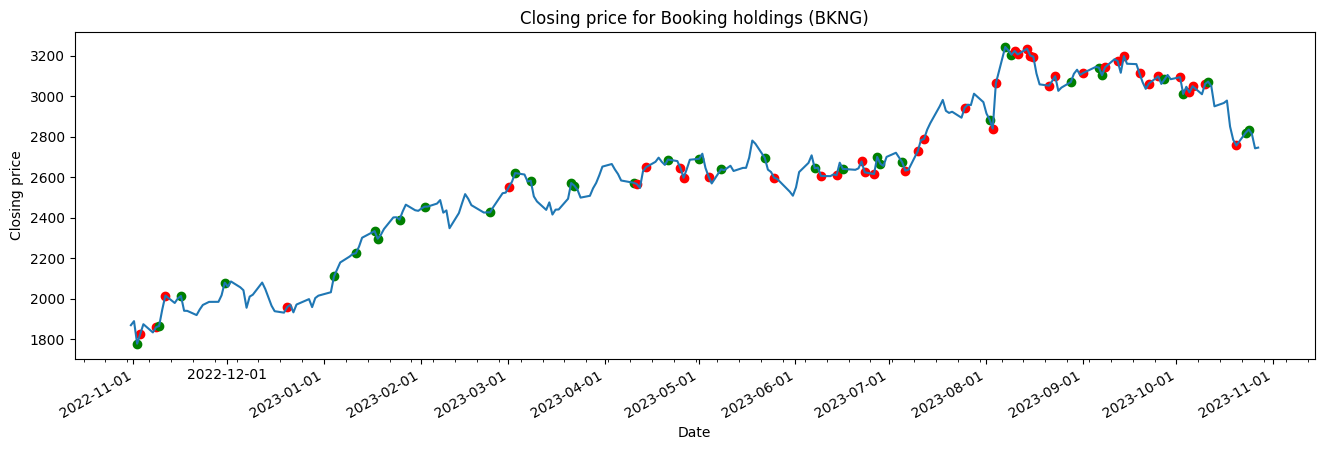

In [70]:
closing = price_history.get('Close')

fig, ax = plt.subplots()

fig.set_figwidth(16)

x = closing.index.to_pydatetime()
y = closing

ax.set_title(f'Closing price for {KEYWORD} ({SYMBOL})')

ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

ax.set_ylabel('Closing price')

for date in x:
  price = closing[date]
  
  d = datetime(date.year, date.month, date.day)
  
  sentiment = sentiment_per_day.get(d)
  
  color = 'green' if sentiment and sentiment > 0 else 'red'
  
  # print(f'Datetime: {d} sentiment: {sentiment} color: {color}')
  
  if sentiment != None:
    ax.scatter(date, price, color=color)

ax.plot(x, y)